# Notícias G1 - 10. Classificação com Deep Learning LSTM

Será feita a classificação das notícias de categoria desconhecida com base no modelo Long Short Term Memory.



## Imports:

Importes de bibliotecas usadas com frequência no código.

In [212]:
import pandas as pd
import numpy as np

## Recuperando Dados Gravados:

Recuperando dados gravados após higienização, stemmer e stop words.

In [213]:
noticias = pd.read_csv('noticias_g1_higienizadas.csv')
print(noticias.shape)
noticias.head()

(3834, 5)


,titulo,url,texto,categoria,dado_tratado
0,Entenda como uma ampla coalizão tirou Netanyah...,https://g1.globo.com/mundo/noticia/2021/06/13/...,O Parlamento de Israel confirmou neste doming...,FALTANDO,"['entend', 'ampl', 'coaliz', 'tir', 'netanyahu..."
1,"Milionário de direita: quem é Naftali Bennett,...",https://g1.globo.com/mundo/noticia/2021/06/13/...,"Milionário do setor de tecnologia, Naftali Be...",FALTANDO,"['milionri', 'direit', 'naftal', 'bennett', 'n..."
2,Governo de SP antecipa datas de vacinação; vej...,https://g1.globo.com/sp/sao-paulo/noticia/2021...,O governo de São Paulo antecipou em 30 dias o...,FALTANDO,"['govern', 'sp', 'antecip', 'dat', 'vacina', '..."
3,PMs que mataram homens dentro de carro em SP s...,https://g1.globo.com/sp/sao-paulo/noticia/2021...,A Polícia Militar instaurou um inquérito poli...,FALTANDO,"['pm', 'mat', 'hom', 'dentr', 'carr', 'sp', 's..."
4,"Após Venezuela e Bolívia, Colômbia confirma 2 ...",https://ge.globo.com/futebol/copa-america/noti...,A Federação Colombiana de Futebol informou ne...,diversos,"['ap', 'venezuel', 'bolv', 'colmb', 'confirm',..."


## Separando Massa Conhecida e Desconhecida:

Parte dos dados dessa base está marcada na coluna "categoria" como "FALTANDO". Essa é a massa de dados que desejamos classificar após o treinamento do modelo. As demais linhas já contém uma categoria conhecida e vamos usar essa massa para treino e teste do modelo.

In [214]:
know_data = noticias[noticias.categoria != 'FALTANDO']
unknow_data = noticias[noticias.categoria == 'FALTANDO']
print("Dados separados: Massa conhecida={}, Massa desconhecida={}".format(know_data.shape, unknow_data.shape))

Dados separados: Massa conhecida=(1723, 5), Massa desconhecida=(2111, 5)


## Dicionário de Palavras:

A seguir iremos gerar o dicionário de palavras do problema conforme parâmetros abaixo:
* num_words é o tamanho máximo do dicionário de palavras.
* filters são filtros para remover caracteres especiais caso haja.
* lower transforma as palavras em caracteres minúsculos.

In [215]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=50000, filters='\'!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(noticias['dado_tratado'])
vocabulary = tokenizer.word_index

print('Found %s unique tokens.' % len(vocabulary))

Found 25758 unique tokens.


## Vetorização:

Precisamos vetorizar o texto de modo que seja transformado em uma sequencia de números inteiros que possa ser processado pela rede neural.

In [216]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_know = tokenizer.texts_to_sequences(know_data['dado_tratado'].values)
X_unknow = tokenizer.texts_to_sequences(unknow_data['dado_tratado'].values)

print('Resultado da vetorização:\n\n', X_know[4], '\n\n', X_unknow[4])

Resultado da vetorização:

 [640, 270, 1868, 3160, 68, 698, 640, 1097, 13327, 86, 82, 2, 329, 56, 42, 59, 5115, 1868, 3160, 301, 230, 2, 30, 1868, 511, 868, 319, 20, 1958, 1052, 1405, 1990, 271, 77, 2412, 1155, 133, 3850, 3941, 1050, 1868, 31, 67, 633, 12, 698, 2, 186, 42, 234, 4, 82, 207, 997, 13328, 1868, 558, 2019, 424, 821, 1854, 56, 770, 914, 234, 5, 4662, 1868, 3011, 921, 3779, 33, 1759, 76, 3861, 1368, 186, 4, 6226, 217, 113, 295, 1585, 87, 350, 260, 92, 359, 9090, 11335, 1211, 6227, 4663, 472, 11336, 720, 11337, 11338, 11339, 11340, 794, 11341, 720, 11342, 11343, 11344, 11345, 10014, 11346, 345, 2829, 170, 2137, 1681, 278, 11347, 580, 11348, 471, 706, 489, 1052, 1489, 4, 34, 278, 1328, 720, 11349, 11350] 

 [3155, 3372, 2063, 57, 1138, 153, 4324, 6899, 3155, 3372, 2063, 57, 13, 284, 35, 1, 147, 1840, 1138, 3373, 5287, 1138, 4324, 6899, 1261, 595, 2157, 3155, 486, 4324, 6899, 32, 84, 50, 784, 147, 57, 111, 1138, 2134, 5103, 5946, 1327, 35, 4541, 970, 2226, 1852, 1824, 351, 841, 

## Padronizando Tamanho das Notícias

Vamos padronizar o tamanho das notícias truncando a partir de um número máximo de palavras e completando com zeros à esquerda nos casos em que a notícia não satisfizer esse máximo. Para tanto os seguintes parâmetros serão usados:

* padding: indica em que posição (antes ou depois do texto) será feito o complemento com zeros caso a notícia tenha menos que a quantidade de palavras esperada;

* truncating: indica em que posição (no início ou no final) o texto será truncado;

* maxlen: é o número máximo de palavras por notícia.

In [217]:
X_know = pad_sequences(X_know, padding='post', truncating='post', maxlen=250)
X_unknow = pad_sequences(X_unknow, padding='post', truncating='post', maxlen=250)

print('Resultado da padronização:', X_know.shape, X_unknow.shape, '\n\n', X_know[4], '\n\n', X_unknow[4])

Resultado da padronização: (1723, 250) (2111, 250) 

 [  640   270  1868  3160    68   698   640  1097 13327    86    82     2
   329    56    42    59  5115  1868  3160   301   230     2    30  1868
   511   868   319    20  1958  1052  1405  1990   271    77  2412  1155
   133  3850  3941  1050  1868    31    67   633    12   698     2   186
    42   234     4    82   207   997 13328  1868   558  2019   424   821
  1854    56   770   914   234     5  4662  1868  3011   921  3779    33
  1759    76  3861  1368   186     4  6226   217   113   295  1585    87
   350   260    92   359  9090 11335  1211  6227  4663   472 11336   720
 11337 11338 11339 11340   794 11341   720 11342 11343 11344 11345 10014
 11346   345  2829   170  2137  1681   278 11347   580 11348   471   706
   489  1052  1489     4    34   278  1328   720 11349 11350     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0    

## Divisão em Treino e Teste:

Vamos dividir a base de dados em massa para treino (70%) e massa para teste (30%).

In [218]:
# ver se tem train_test_split stratified

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_know, know_data['categoria'], test_size=0.30, 
    random_state=33, stratify=know_data['categoria'])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1206, 250) (517, 250) (1206,) (517,)


## One Hot Encoder:

Como trata-se de um problema multiclasse vamos precisar utilizar a técnica one-hot-encoding. Nessa técnica é criada uma matriz onde cada classe torna-se uma coluna e, para cada registro, apenas a coluna da classe correta é sinalizada com valor 1, as demais colunas permanecem com zeros. 

O objetivo disso e tornar variáveis categóricas processáveis pela rede neural sem, contudo, utilizar ordem de grandeza pela atribuição de números inteiros - técnica conhecida como label enconding.

In [219]:
from sklearn.preprocessing import OneHotEncoder

df_cat_treino = pd.DataFrame(y_train)

one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(df_cat_treino.to_numpy())
ohe_cat_treino = one_hot_encoder.transform(df_cat_treino.to_numpy())

df_one_hot_encoder = pd.DataFrame(ohe_cat_treino)
df_one_hot_encoder.columns = one_hot_encoder.categories_

df_one_hot_encoder

,diversos,economia,educacao,politica,pop-arte,saude
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
1201,0.0,0.0,0.0,1.0,0.0,0.0
1202,0.0,0.0,0.0,1.0,0.0,0.0
1203,0.0,0.0,1.0,0.0,0.0,0.0
1204,0.0,0.0,0.0,1.0,0.0,0.0


## Tratando Desbalanceamento das Classes:

Como as classes estão muito desbalanceadas faremos o tratamento desse problema por meio do ajuste dos pesos para cada categoria. Isso será feito usando o sklearn.

In [220]:
from sklearn.utils import class_weight

sm_one_hot_encoder = np.array(ohe_cat_treino)

y_integers = np.argmax(sm_one_hot_encoder, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 28.714285714285715,
 1: 0.44370860927152317,
 2: 5.911764705882353,
 3: 0.5809248554913294,
 4: 0.8893805309734514,
 5: 1.4357142857142857}

## Transformando Labels das Categorias em Números:

Cria uma coluna com o índice correspondente a cada classe no dataframe de categorias da amostra de teste.

In [221]:
categorys = one_hot_encoder.categories_[0]
df_cat_teste = pd.DataFrame(y_test)

for x in range (0, len(categorys)):
    df_cat_teste.loc[df_cat_teste['categoria'] == categorys[x], 'index'] = x

df_cat_teste

,categoria,index
2521,politica,3.0
2234,politica,3.0
697,economia,1.0
682,economia,1.0
3421,economia,1.0
...,...,...
917,saude,5.0
170,economia,1.0
1031,saude,5.0
349,economia,1.0


## LSTM - Configuração:

Configura a rede para classificação com LSTM.

In [222]:
import tensorflow as tf

model = tf.keras.Sequential([

    # Add an embedding layer expecting input vocab and output embedding dimension
    tf.keras.layers.Embedding(input_dim=len(vocabulary), output_dim=64, input_length=250),
    
    # Bidiretional layer with LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
    
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(32, activation='relu'),
    
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 250, 64)           1648512   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dense_38 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 198       
Total params: 1,718,886
Trainable params: 1,718,886
Non-trainable params: 0
_________________________________________________________________


## LSTM - Treinamento:

Realiza o treinamento para classificação com LSTM.

In [223]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    pd.DataFrame(X_train),
    df_one_hot_encoder,
    batch_size=32,
    epochs = 150,
    validation_data=(pd.DataFrame(X_test), df_cat_teste['index']), 
    #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)],
    #validation_split=0.1,
    verbose = 2
)

Epoch 1/150
38/38 - 13s - loss: 0.1260 - accuracy: 0.3673 - val_loss: 8.1457 - val_accuracy: 0.0000e+00
Epoch 2/150
38/38 - 8s - loss: 0.0790 - accuracy: 0.6418 - val_loss: 8.2088 - val_accuracy: 0.0000e+00
Epoch 3/150
38/38 - 8s - loss: 0.0363 - accuracy: 0.8408 - val_loss: 8.2005 - val_accuracy: 0.0000e+00
Epoch 4/150
38/38 - 8s - loss: 0.0222 - accuracy: 0.9312 - val_loss: 8.2238 - val_accuracy: 0.0000e+00
Epoch 5/150
38/38 - 8s - loss: 0.0139 - accuracy: 0.9527 - val_loss: 8.2296 - val_accuracy: 0.0000e+00
Epoch 6/150
38/38 - 7s - loss: 0.0114 - accuracy: 0.9585 - val_loss: 8.2251 - val_accuracy: 0.0000e+00
Epoch 7/150
38/38 - 7s - loss: 0.0100 - accuracy: 0.9594 - val_loss: 8.2266 - val_accuracy: 0.0000e+00
Epoch 8/150
38/38 - 8s - loss: 0.0079 - accuracy: 0.9652 - val_loss: 8.2187 - val_accuracy: 0.0000e+00
Epoch 9/150
38/38 - 7s - loss: 0.0052 - accuracy: 0.9818 - val_loss: 8.2238 - val_accuracy: 0.0000e+00
Epoch 10/150
38/38 - 8s - loss: 0.0038 - accuracy: 0.9884 - val_loss: 8.

38/38 - 8s - loss: 2.7704e-04 - accuracy: 0.9992 - val_loss: 8.2477 - val_accuracy: 0.0077
Epoch 81/150
38/38 - 8s - loss: 2.7657e-04 - accuracy: 0.9992 - val_loss: 8.2477 - val_accuracy: 0.0077
Epoch 82/150
38/38 - 8s - loss: 2.7551e-04 - accuracy: 0.9992 - val_loss: 8.2476 - val_accuracy: 0.0077
Epoch 83/150
38/38 - 7s - loss: 2.7203e-04 - accuracy: 0.9992 - val_loss: 8.2473 - val_accuracy: 0.0077
Epoch 84/150
38/38 - 8s - loss: 2.3997e-04 - accuracy: 0.9992 - val_loss: 8.2440 - val_accuracy: 0.0077
Epoch 85/150
38/38 - 8s - loss: 7.2395e-04 - accuracy: 0.9983 - val_loss: 8.2401 - val_accuracy: 0.0135
Epoch 86/150
38/38 - 8s - loss: 0.0045 - accuracy: 0.9842 - val_loss: 8.2424 - val_accuracy: 0.0097
Epoch 87/150
38/38 - 7s - loss: 0.0053 - accuracy: 0.9809 - val_loss: 8.2423 - val_accuracy: 0.0000e+00
Epoch 88/150
38/38 - 8s - loss: 0.0036 - accuracy: 0.9867 - val_loss: 8.2381 - val_accuracy: 0.0000e+00
Epoch 89/150
38/38 - 8s - loss: 0.0023 - accuracy: 0.9934 - val_loss: 8.2452 - va

## Resultado do Treinamento:

Resultado apurado após o treinamento do modelo.

In [224]:
accr = model.evaluate(pd.DataFrame(X_test), df_cat_teste['index'])
print(accr)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

17/17 [==============================] - 1s 52ms/step - loss: 8.2440 - accuracy: 0.0174
[8.244032859802246, 0.01740812323987484]
Test set
  Loss: 8.244
  Accuracy: 0.017


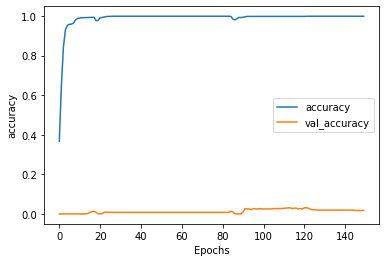

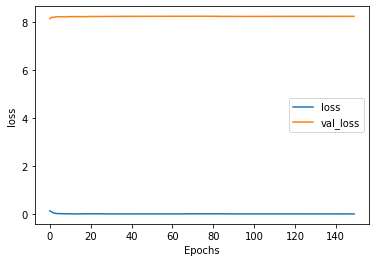

In [225]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Classificação da Massa de Teste:

Será realizado teste com a massa de dados separada para esse fim. Os resultados serão avaliados mais abaixo.

In [226]:
result = model.predict(pd.DataFrame(X_test))
classificacao_massa_teste = []
for pred in result:
    classificacao_massa_teste.append(categorys[np.argmax(pred)])
len(classificacao_massa_teste)

517

## Teste com Notícias Fictícias:

Teste com algumas notícias fictícias cujo contexto seja bastante claro.

In [227]:
def higienizar_texto (texto):
  import re
  texto = re.sub('[^A-Za-z\-\s]', '', texto)
  texto = re.sub('(\-..es)|(\-..e)|(\-.e)|(\-.os)|(\-ei)', '', texto)
  texto = re.sub('\-+', '', texto)
  return texto.lower()

In [228]:
import nltk
nltk.download('rslp')

from nltk.stem import RSLPStemmer
stemmer_ptbr = RSLPStemmer()

def apply_stem (text):
    return [stemmer_ptbr.stem(word) for word in text]

[nltk_data] Downloading package rslp to /Users/edprata/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [229]:
def classificar_noticia(model, nova_noticia):
    higi = higienizar_texto(nova_noticia)
    stemmed = apply_stem(higi.split())
    vectorized = tokenizer.texts_to_sequences([stemmed])
    padded = pad_sequences(vectorized, padding='post', truncating='post', maxlen=250)
    predic = model.predict(padded)
    return predic, categorys[np.argmax(predic)]

In [230]:
array_noticias = [
    'Exemplo de notícia inventada onde uma ação do governo causou instabilidade na bolsa e aumentou o dolar e o preço das mercadorias.',
    'Notícia em que as escolas foram fechadas, professores ficaram parados, meses sem aulas impactando nas vidas das familias, o ministério da educação nada faz.',
    'Os prefeitos não trataram adequadamente a crise e a população sofre as consequencias desse problema, os vereadores nada fazem, políticos não prestam',
    'Em Minas Gerais acontece grande show com presença de famosos mesmo em plena pandemia para divertir a multidão',
    'Um surto de gripe castiga a população do Rio Grande do Norte e os prefeitos buscam por alternativas'
]

for noticia in array_noticias:
    print(classificar_noticia(model, noticia))

(array([[0.12598488, 0.08178825, 0.38132453, 0.03829517, 0.35120267,
        0.0214045 ]], dtype=float32), 'educacao')
(array([[0.02817476, 0.03687306, 0.8903814 , 0.02370007, 0.01247162,
        0.00839913]], dtype=float32), 'educacao')
(array([[0.01316405, 0.26657537, 0.66059524, 0.04668476, 0.00898204,
        0.00399859]], dtype=float32), 'educacao')
(array([[5.5195154e-03, 2.8310979e-03, 8.7170862e-04, 4.7061265e-05,
        9.9071127e-01, 1.9388721e-05]], dtype=float32), 'pop-arte')
(array([[0.25213957, 0.00151601, 0.00904335, 0.00301815, 0.69373953,
        0.04054344]], dtype=float32), 'pop-arte')


In [231]:
categorys

array(['diversos', 'economia', 'educacao', 'politica', 'pop-arte',
       'saude'], dtype=object)

## Classificação da Base Desconhecida:

Classificação da massa de dados cuja categoria não conhecemos a partir do modelo treinado.

In [232]:
# Classificação:
classification = model.predict(X_unknow)

# Transformando índices em categorias legíveis:
result = []
for line in classification:
    result.append(categorys[np.argmax(line)])

classificacao_massa_desconhecida = result
np.unique(classificacao_massa_desconhecida)

array(['diversos', 'economia', 'educacao', 'politica', 'pop-arte',
       'saude'], dtype='<U8')

## Análise dos Resultados: Distribuição por Categoria:

Elabora gráficos para comparar a distribuição dos dados na massa de treino, de teste, e de classificação (cuja categoria é desconhecida).

In [233]:
# Calculando a distribuição:

from collections import Counter, OrderedDict

counter = sorted(Counter(df_cat_treino['categoria']).items(), key=lambda i: i[0])
dist_treino = pd.DataFrame(counter, columns=['cat', 'qtd'])

counter = sorted(Counter(df_cat_teste['categoria']).items(), key=lambda i: i[0])
dist_teste = pd.DataFrame(counter, columns=['cat', 'qtd'])

counter = sorted(Counter(classificacao_massa_teste).items(), key=lambda i: i[0])
dist_teste_ = pd.DataFrame(counter, columns=['cat', 'qtd'])

counter = sorted(Counter(classificacao_massa_desconhecida).items(), key=lambda i: i[0])
dist_classificacao = pd.DataFrame(counter, columns=['cat', 'qtd'])

print(dist_teste.shape, dist_teste_.shape, dist_classificacao.shape)

(6, 2) (6, 2) (6, 2)


/Users/edprata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


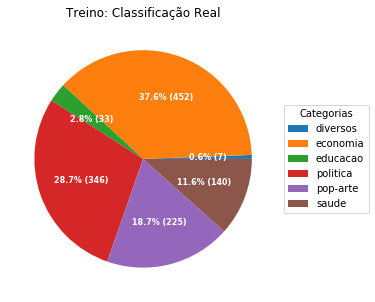

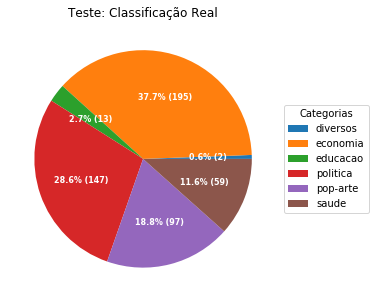

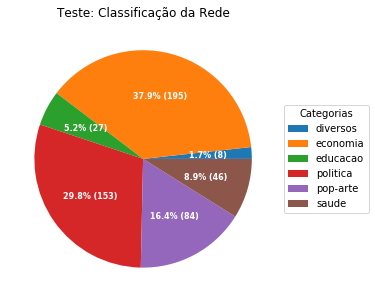

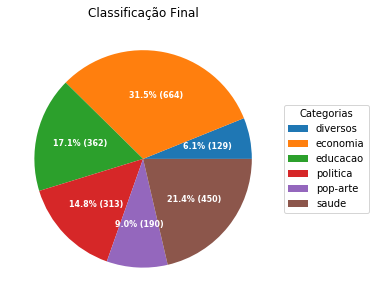

In [234]:
import matplotlib.pyplot as plt

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d})".format(pct, absolute)

def pie(title, legend, data, label):
  fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(aspect="equal"))
  wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))
  ax.legend(wedges, label, title=legend, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
  plt.setp(autotexts, size=8, weight="bold")
  ax.set_title(title)
  plt.show()

pie("Treino: Classificação Real", "Categorias", dist_treino[['qtd']], dist_teste['cat'])
pie("Teste: Classificação Real", "Categorias", dist_teste[['qtd']], dist_teste['cat'])
pie("Teste: Classificação da Rede", "Categorias", dist_teste_[['qtd']], dist_teste_['cat'])
pie("Classificação Final", "Categorias", dist_classificacao[['qtd']], dist_classificacao['cat'])